# 0. Install and Import Dependencies

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.32.1
aiohappyeyeballs                 2.3.5
aiohttp                          3.10.2
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.13
albumentations                   1.4.13
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.18.0
asn1crypto                       1.5.1
astropy                          6.1.2
astropy-iers-data                0.2024.8.5.0.32.23
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            24.2.0
audioread               

In [ ]:
!pip install opencv-python==4.6.0.66 tensorflow==2.10.1 imageio==2.23.0 matplotlib==3.6.2 gdown==4.6.0

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
tf.config.list_physical_devices('GPU')

[]

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    pass

# 1. Build Data Loading Functions

In [ ]:
def load_video(path:str) -> List[float]:

    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [ ]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [ ]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size ={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size =40)


In [ ]:
char_to_num.get_vocabulary()

['',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 "'",
 '?',
 '!',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ' ']

In [ ]:
char_to_num(['n','i','c','k'])

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([14,  9,  3, 11])>

In [ ]:
num_to_char([14,  9,  3, 11])

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'n', b'i', b'c', b'k'], dtype=object)>

In [ ]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [ ]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

In [ ]:
test_path = './data/s1/bbal6n.mpg'

In [ ]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('/')[-1].split('.')[0]

'bbal6n'

In [ ]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

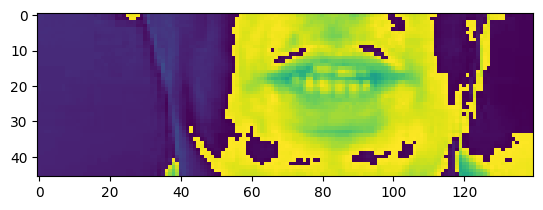

In [ ]:
plt.imshow(frames[40])

In [ ]:
alignments

<tf.Tensor: shape=(21,), dtype=int64, numpy=
array([ 2,  9, 14, 39,  2, 12, 21,  5, 39,  1, 20, 39, 12, 39, 19,  9, 24,
       39, 14, 15, 23])>

In [ ]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [ ]:
from typing import Tuple
def mappable_function(path:str) ->Tuple[tf.Tensor, tf.Tensor]:
      result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
      return result

# 2. Create Data Pipeline

In [ ]:
from matplotlib import pyplot as plt

In [ ]:
data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)
# Added for split
train = data.take(450)
test = data.skip(450)

In [ ]:
len(test)

50

In [ ]:
frames, alignments = data.as_numpy_iterator().next()

In [ ]:
len(frames)

2

In [ ]:
frames

array([[[[[ 1.4994212 ],
          [ 1.46285   ],
          [ 0.91428125],
          ...,
          [ 0.40228376],
          [ 0.3657125 ],
          [ 0.3657125 ]],

         [[ 1.4262787 ],
          [ 1.2434225 ],
          [ 0.8411387 ],
          ...,
          [ 0.40228376],
          [ 0.3657125 ],
          [ 0.3657125 ]],

         [[ 1.3531363 ],
          [ 1.5359925 ],
          [ 1.46285   ],
          ...,
          [ 0.40228376],
          [ 0.40228376],
          [ 0.40228376]],

         ...,

         [[ 1.1337087 ],
          [ 1.0971375 ],
          [ 1.0971375 ],
          ...,
          [ 0.10971375],
          [ 0.10971375],
          [ 0.10971375]],

         [[ 1.0971375 ],
          [ 1.0971375 ],
          [ 1.0971375 ],
          ...,
          [ 0.10971375],
          [ 0.10971375],
          [ 0.10971375]],

         [[ 1.0971375 ],
          [ 1.0971375 ],
          [ 1.0971375 ],
          ...,
          [ 0.10971375],
          [ 0.10971375],
          

In [ ]:
sample = data.as_numpy_iterator()

In [ ]:
val = sample.next(); val[0]

array([[[[[ 1.2987053 ],
          [ 1.2987053 ],
          [ 1.4610435 ],
          ...,
          [ 0.20292272],
          [ 0.16233817],
          [ 0.16233817]],

         [[ 1.2987053 ],
          [ 1.2987053 ],
          [ 1.4610435 ],
          ...,
          [ 0.20292272],
          [ 0.16233817],
          [ 0.16233817]],

         [[ 1.4610435 ],
          [ 1.4610435 ],
          [ 1.420459  ],
          ...,
          [ 0.24350725],
          [ 0.16233817],
          [ 0.16233817]],

         ...,

         [[ 0.974029  ],
          [ 0.974029  ],
          [ 0.974029  ],
          ...,
          [10.308474  ],
          [10.308474  ],
          [10.308474  ]],

         [[ 0.9334445 ],
          [ 0.9334445 ],
          [ 0.9334445 ],
          ...,
          [10.308474  ],
          [10.308474  ],
          [10.308474  ]],

         [[ 0.9334445 ],
          [ 0.9334445 ],
          [ 0.9334445 ],
          ...,
          [10.308474  ],
          [10.308474  ],
          

In [ ]:
print(val)

(array([[[[[ 1.2987053 ],
          [ 1.2987053 ],
          [ 1.4610435 ],
          ...,
          [ 0.20292272],
          [ 0.16233817],
          [ 0.16233817]],

         [[ 1.2987053 ],
          [ 1.2987053 ],
          [ 1.4610435 ],
          ...,
          [ 0.20292272],
          [ 0.16233817],
          [ 0.16233817]],

         [[ 1.4610435 ],
          [ 1.4610435 ],
          [ 1.420459  ],
          ...,
          [ 0.24350725],
          [ 0.16233817],
          [ 0.16233817]],

         ...,

         [[ 0.974029  ],
          [ 0.974029  ],
          [ 0.974029  ],
          ...,
          [10.308474  ],
          [10.308474  ],
          [10.308474  ]],

         [[ 0.9334445 ],
          [ 0.9334445 ],
          [ 0.9334445 ],
          ...,
          [10.308474  ],
          [10.308474  ],
          [10.308474  ]],

         [[ 0.9334445 ],
          [ 0.9334445 ],
          [ 0.9334445 ],
          ...,
          [10.308474  ],
          [10.308474  ],
         

In [ ]:
import imageio
imageio.mimsave('./animation.gif', val[0][0], fps=10)

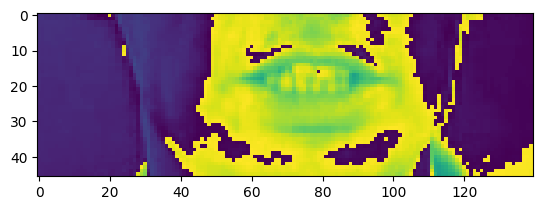

In [ ]:
# 0:videos, 0: 1st video out of the batch,  0: return the first frame in the video
plt.imshow(val[0][0][35])

In [ ]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'place green in d six please'>

# 3. Design the Deep Neural Network

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [ ]:
data.as_numpy_iterator().next()[0][0].shape

(75, 46, 140, 1)

In [ ]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 75, 46, 140, 128)  3584      
                                                                 
 activation (Activation)     (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 75, 23, 70, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_1 (Activation)   (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 75, 11, 35, 256)  0         
 3D)                                                    

In [ ]:
yhat = model.predict(val[0])

1/1 [==============================] - 22s 22s/step


In [ ]:
tf.strings.reduce_join([num_to_char(x) for x in tf.argmax(yhat[0],axis=1)])

<tf.Tensor: shape=(), dtype=string, numpy=b"'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''">

In [ ]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[0]])

<tf.Tensor: shape=(), dtype=string, numpy=b"'''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''''">

In [ ]:
model.input_shape

(None, 75, 46, 140, 1)

In [ ]:
model.output_shape

(None, 75, 41)

# 4. Setup Training Options and Train

In [ ]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [ ]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [ ]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = dataset.as_numpy_iterator()

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = self.dataset.next()
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75,75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~'*100)

In [ ]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [ ]:
checkpoint_callback = ModelCheckpoint(('./models/checkpoint'), monitor='loss', save_weights_only=True)

In [ ]:
schedule_callback = LearningRateScheduler(scheduler)

In [ ]:
example_callback = ProduceExample(test)

In [ ]:
model.fit(train, validation_data=test, epochs=2, callbacks=[checkpoint_callback, schedule_callback, example_callback])

# 5. Make a Prediction

In [ ]:
model.load_weights('./models/checkpoint')

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
sample = test_data.next()

In [ ]:
yhat = model.predict(sample[0])

1/1 [==============================] - 15s 15s/step


In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue with d one again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set white with v six now'>]

In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'place blue with d one again'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set white with v six now'>]

# Test on a Video

In [ ]:
sample = load_data(tf.convert_to_tensor('./data/s1/bras9a.mpg'))

In [ ]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

In [ ]:
yhat = model.predict(tf.expand_dims(sample[0], axis=0))

1/1 [==============================] - 8s 8s/step


In [ ]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()

In [ ]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin red at s nine again'>]

# Accuracy and CER

In [ ]:
true_text= [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in [sample[1]]]
predicted_text = [tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

In [ ]:
!pip install editdistance

In [ ]:
import editdistance
def calculate_accuracy(true_text, predicted_text):
    return int(true_text == predicted_text)

# Function to calculate Character Error Rate (CER)
def calculate_cer(true_text, predicted_text):
    # Convert TensorFlow Tensors to NumPy arrays and then decode to strings
    true_text_str = true_text[0].numpy().decode('utf-8')
    predicted_text_str = predicted_text[0].numpy().decode('utf-8')
    #Calculate distance
    distance = editdistance.eval(true_text_str, predicted_text_str)
    cer = distance / len(true_text) if len(true_text) > 0 else 0
    return cer

# Calculate accuracy
accuracy = calculate_accuracy(true_text, predicted_text)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Calculate CER
cer = calculate_cer(true_text, predicted_text)
print(f'Character Error Rate (CER): {cer:.4f}')

Accuracy: 100.00%
Character Error Rate (CER): 0.0000


In [ ]:
import numpy as np
import editdistance

def calculate_accuracy(true_texts, predicted_texts):
    correct_count = sum([true == pred for true, pred in zip(true_texts, predicted_texts)])
    return correct_count / len(true_texts)

def calculate_cer(true_texts, predicted_texts):
    cer_list = []
    for true, pred in zip(true_texts, predicted_texts):
        distance = editdistance.eval(true, pred)
        cer = distance / len(true) if len(true) > 0 else 0
        cer_list.append(cer)
    return np.mean(cer_list)


In [ ]:
import tensorflow as tf
import numpy as np

def expand_channels(video):
    # Remove the batch dimension and convert to numpy array
    video_np = tf.squeeze(video).numpy()  # Remove the batch dimension (1) and convert to numpy array

    # Expand the channel dimension from 1 to 128
    expanded_video_np = np.repeat(video_np, 128, axis=-1)  # Repeat along the last dimension

    # Convert back to TensorFlow tensor
    expanded_video = tf.convert_to_tensor(expanded_video_np)

    return expanded_video

# Assuming video is a tensor with shape (1, 75, 46, 140, 1)
video = tf.random.uniform((1, 75, 46, 140, 1))  # Replace with your actual data
expanded_video = expand_channels(video)
print(expanded_video.shape)  # Should output: (75, 46, 140, 128)


(75, 46, 140)


In [ ]:
# def evaluate_model(model, dataset, num_examples=50):
#     true_texts = []
#     predicted_texts = []

#     # Sample 100 examples from the dataset
#     sample_data = dataset.take(num_examples)

#     for video, alignments in sample_data:
#         # Convert video to tensor and make prediction
#         video = tf.expand_dims(video, axis=0)
#         yhat = model.predict(tf.expand_dims(video, axis=0))
#         # Decode the predictions
#         decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
#         predicted_text = tf.strings.reduce_join([num_to_char(word) for word in decoded]).numpy().decode('utf-8')

#         # Extract true text
#         true_text = tf.strings.reduce_join([num_to_char(word) for word in alignments]).numpy().decode('utf-8')

#         # Append results
#         true_texts.append(true_text)
#         predicted_texts.append(predicted_text)

#     # Calculate metrics
#     accuracy = calculate_accuracy(true_texts, predicted_texts)
#     cer = calculate_cer(true_texts, predicted_texts)

#     return accuracy, cer
def evaluate_model(model, test_data, num_examples=50):
    true_texts = []
    predicted_texts = []
    total_cer = 0
    total_accuracy = 0

    for i, (video, text) in enumerate(test_data.take(num_examples)):
        # Ensure video has the correct shape
        video_shape = video.shape
        # video = expand_channels(video)
        if video_shape != (75, 46, 140, 128):
            print(f"Unexpected video shape: {video_shape}. Expected: (75, 46, 140, 128)")
            continue

        # Perform prediction
        yhat = model.predict(tf.expand_dims(video, axis=0))

        # Decode the prediction
        decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75], greedy=True)[0][0].numpy()
        predicted_text = [num_to_char(word) for sentence in decoded for word in sentence]

        # Decode the true text
        true_text = [num_to_char(word) for word in text]

        # Calculate CER and accuracy
        cer = character_error_rate(''.join(true_text), ''.join(predicted_text))
        accuracy = accuracy_score([true_text], [predicted_text])
        total_cer += cer
        total_accuracy += accuracy

        true_texts.append(''.join(true_text))
        predicted_texts.append(''.join(predicted_text))

    average_cer = total_cer / num_examples
    average_accuracy = total_accuracy / num_examples

    return average_accuracy, average_cer, true_texts, predicted_texts

def character_error_rate(true_text, predicted_text):
    return cer(true_text, predicted_text)

def accuracy_score(true_texts, predicted_texts):
    correct = sum(1 for t, p in zip(true_texts, predicted_texts) if t == p)
    return correct / len(true_texts)

def expand_channels(video):
    # Convert to numpy for manipulation (if using TensorFlow, you can use tensor operations directly)
    video_np = video.numpy().squeeze()  # Remove the batch dimension and convert to numpy array
    expanded_video_np = np.repeat(video_np, 128, axis=-1)  # Repeat along the last dimension

    # Convert back to TensorFlow tensor
    expanded_video = tf.convert_to_tensor(expanded_video_np)

    return expanded_video


# Load test dataset
test_data = tf.data.Dataset.list_files('/content/data/s1/*.mpg')
test_data = test_data.map(mappable_function)
test_data = test_data.padded_batch(128, padded_shapes=([75,46,140],[40]))
test_data = test_data.prefetch(tf.data.AUTOTUNE)

# Evaluate the model
accuracy, cer = evaluate_model(model, test_data, num_examples=50)

print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Character Error Rate (CER): {cer:.4f}')


InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} All elements in a batch must have the same rank as the padded shape for component0: expected rank 3 but got element with rank 4 [Op:IteratorGetNext]

# Streamlit Application

In [ ]:
!pip list

Package                          Version
-------------------------------- ---------------------
absl-py                          1.4.0
accelerate                       0.32.1
aiohappyeyeballs                 2.3.5
aiohttp                          3.10.2
aiosignal                        1.3.1
alabaster                        0.7.16
albucore                         0.0.13
albumentations                   1.4.13
altair                           4.2.2
annotated-types                  0.7.0
anyio                            3.7.1
argon2-cffi                      23.1.0
argon2-cffi-bindings             21.2.0
array_record                     0.5.1
arviz                            0.18.0
asn1crypto                       1.5.1
astropy                          6.1.2
astropy-iers-data                0.2024.8.5.0.32.23
astunparse                       1.6.3
async-timeout                    4.0.3
atpublic                         4.1.0
attrs                            24.2.0
audioread               

In [ ]:
!pip install opencv-python==4.6.0.66 tensorflow==2.10.1 imageio==2.23.0 matplotlib==3.6.2 gdown==4.6.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 42.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 38.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 36.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled ke

In [ ]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [ ]:
!pip install streamlit -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.3/309.3 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires protobuf<5,>=3.20, but you have protobuf 5.27.3 which is incompatible.
google-ai-generativelanguage 0.6.6 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 5.27.3 which is incompatible.
google-cloud-aiplatform 1.59.0 requires protobuf!=3.20.0,!=3

In [ ]:
#to resolve error
!pip install protobuf==3.20.0
!export PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python


In [ ]:
!wget -q -O - ipv4.icanhazip.com

34.72.227.47


In [ ]:
%%writefile modelutil.py
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten

def load_model() -> Sequential:
    model = Sequential()

    model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(256, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(Conv3D(75, 3, padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool3D((1,2,2)))

    model.add(TimeDistributed(Flatten()))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Bidirectional(LSTM(128, kernel_initializer='Orthogonal', return_sequences=True)))
    model.add(Dropout(.5))

    model.add(Dense(41, kernel_initializer='he_normal', activation='softmax'))

    model.load_weights('./models/checkpoint')

    return model

Overwriting modelutil.py


In [ ]:
%%writefile utils.py
import tensorflow as tf
from typing import List
import cv2
import os

vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
# Mapping integers back to original characters
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

def load_video(path:str) -> List[float]:
    #print(path)
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236,80:220,:])
    cap.release()

    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

def load_alignments(path:str) -> List[str]:
    #print(path)
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = path.split('/')[-1].split('.')[0]
    # File name splitting for windows
    # file_name = path.split('\\')[-1].split('.')[0]
    video_path = os.path.join('data','s1',f'{file_name}.mpg')
    alignment_path = os.path.join('data','alignments','s1',f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)

    return frames, alignments

Overwriting utils.py


In [ ]:
%%writefile streamlitapp.py
# Import all of the dependencies
import streamlit as st
import os
import imageio
import tensorflow as tf
from utils import load_data, num_to_char
from modelutil import load_model

# Set the layout to the streamlit app as wide
st.set_page_config(layout='wide')

# Setup the sidebar
with st.sidebar:
    st.image('https://www.onepointltd.com/wp-content/uploads/2020/03/inno2.png')
    st.title('LipReading')
    st.info("""
        **Tech Stack Used:**
        - **Streamlit**: ![Streamlit](https://img.shields.io/badge/Streamlit-Streamlit-ff4b4b?logo=streamlit&logoColor=white)
        - **TensorFlow**: ![TensorFlow](https://img.shields.io/badge/TensorFlow-TensorFlow-ff6f00?logo=tensorflow&logoColor=white)
        - **OpenCV**: ![OpenCV](https://img.shields.io/badge/OpenCV-OpenCV-5c3c91?logo=opencv&logoColor=white)
        - **FFmpeg**: ![FFmpeg](https://img.shields.io/badge/FFmpeg-FFmpeg-000000?logo=ffmpeg&logoColor=white)
        - **Python**: ![Python](https://img.shields.io/badge/Python-Python-306998?logo=python&logoColor=white)
    """)

st.title('LipReading App', anchor='top')
st.markdown("""
    **Welcome to the LipReading Application!**

    This application perform lip reading from video inputs.

    **How It Works:**
    - **Video Selection:** Choose a video from the available options.
    - **Video Rendering:** View the selected video as well as its converted form in MP4 format.
    - **Model Processing:** Watch the model process the video and make predictions.
    - **Visualization:** See how the machine learning model views the video and the output of its predictions.
    - **Prediction Decoding:** View the model's prediction in text format.

    The application demonstrates how machine learning can interpret and understand human lip movements to transcribe spoken words.
""", unsafe_allow_html=True)

# Generating a list of options or videos
options = os.listdir(os.path.join('data', 's1'))
selected_video = st.selectbox('Choose video', options, index=0, format_func=lambda x: x.split('/')[-1].replace('_', ' ').title())

# Generate two columns
col1, col2 = st.columns(2)

if options:

    # Rendering the video
    with col1:
        st.info('The video below displays the converted video in MP4 format')
        file_path = os.path.join('data', 's1', selected_video)
        os.system(f'ffmpeg -i {file_path} -vcodec libx264 test_video.mp4 -y')

        # Rendering inside of the app
        video = open('test_video.mp4', 'rb')
        video_bytes = video.read()
        st.video(video_bytes)

    with col2:
        st.info('This is the raw video data as processed by the machine learning model')
        video, annotations = load_data(tf.convert_to_tensor(file_path))
        imageio.mimsave('animation.gif', video, fps=10)
        st.image('animation.gif', width=400)

        st.info('Machine learning model output as tokens')
        model = load_model()
        yhat = model.predict(tf.expand_dims(video, axis=0))
        decoder = tf.keras.backend.ctc_decode(yhat, [75], greedy=True)[0][0].numpy()
        st.text(decoder)

        # Convert prediction to text
        st.info('Decoded prediction as readable text')
        converted_prediction = tf.strings.reduce_join(num_to_char(decoder)).numpy().decode('utf-8')
        st.text(converted_prediction)

# Custom footer
st.markdown("""
    <style>
        .footer {
            text-align: center;
            padding: 1em;
            background-color: #f1f1f1;
            border-top: 1px solid #e0e0e0;
            font-size: 12px;
            color: #555;
        }
    </style>
    <div class="footer">
        Made By Sarthak Bhardwaj
    </div>
""", unsafe_allow_html=True)


Overwriting streamlitapp.py


In [ ]:
!streamlit run streamlitapp.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://34.72.227.47:8501

your url is: https://smart-donuts-dig.loca.lt
2024-08-15 19:13:50.139738: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 19:13:50.315416: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2024-08-15 19:13:50.315475: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on